# <i class="fa-solid fa-puzzle-piece"></i> Regularisation, PCR & PLS

Building on subset selection, an alternative approach is to include all *p* predictors in the model but apply regularization—shrinking the **coefficient estimates toward zero** relative to the least squares estimates. This reduces model complexity without fully discarding variables. Though it introduces some bias, it often lowers variance and improves test performance. 

3 approaches are commonly used to regularize the predictors:
- Ridge Regression (L2 Regression)
- Lasso Regression (L1 Regression)
- Elastic Net Regression


## Today's data: Hitters

For practical demonstration, we will again use the `Hitters` dataset.

In [1]:
import statsmodels.api as sm 

hitters = sm.datasets.get_rdataset("Hitters", "ISLR").data

# Keep 15 variables - the target ´Salary´ and 14 features.
hitters_subset = hitters[["Salary", "AtBat", "Runs","RBI", "CHits", "CAtBat", "CRuns", "CWalks", "Assists", "Hits", "HmRun", "Years", "Errors", "Walks"]].copy()
hitters_subset = hitters_subset.drop(columns=["CRuns", "CAtBat"]) # Remove highly correlated features (see previous session)
hitters_subset.dropna(inplace=True) # drop rows containing missing data

hitters_subset.head()

Salary  AtBat  Runs  RBI  CHits  CWalks  Assists  Hits  \
rownames                                                                    
-Alan Ashby         475.0    315    24   38    835     375       43    81   
-Alvin Davis        480.0    479    66   72    457     263       82   130   
-Andre Dawson       500.0    496    65   78   1575     354       11   141   
-Andres Galarraga    91.5    321    39   42    101      33       40    87   
-Alfredo Griffin    750.0    594    74   51   1133     194      421   169   

                   HmRun  Years  Errors  Walks  
rownames                                        
-Alan Ashby            7     14      10     39  
-Alvin Davis          18      3      14     76  
-Andre Dawson         20     11       3     37  
-Andres Galarraga     10      2       4     30  
-Alfredo Griffin       4     11      25     35

Once again, let's take a look at the correlation between predictors to check for potential multicollinearity, which can affect the stability of linear regression models:

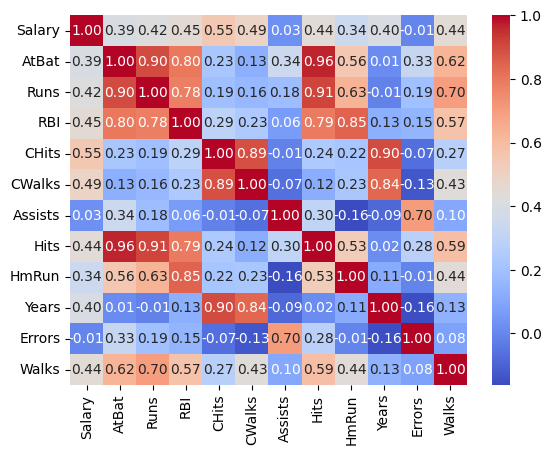

In [2]:
import seaborn as sns

sns.heatmap(hitters_subset.corr(), annot=True, cmap="coolwarm", fmt=".2f");

We now continue to prepare our data by defining target and features and split it into training and test set:

In [3]:
from sklearn.model_selection import train_test_split

y = hitters_subset["Salary"]
X = hitters_subset.drop(columns=["Salary"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Great! We are now ready for using the data in our regression models.


## Ridge Regression

The loss function for ridge regression is defined as:

$$L(\boldsymbol\beta)=\sum_{i=1}^{n}\bigl(y_i - \mathbf X_i\,\boldsymbol\beta\bigr)^2\;+\;\lambda\sum_{j=1}^{p} \beta_j^2$$

Where:

- $n$ is the number of observations
- $p$ is the number of predictors
- $y_i$​ is the target for observation $i$
- $X_i$ is the row vector of features for observation $i$
- $\beta$ are the regression coefficients
- $\lambda$ is the regularization strength

Combined:

- $L(\boldsymbol\beta)=\sum_{i=1}^{n}\bigl(y_i - \mathbf X_i\,\boldsymbol\beta\bigr)^2$ is the **residual sum of squares (RSS)**
- $\lambda\sum_{j=1}^{p} \beta_j^2$ is the **L2 penalty** on the coefficients 

```{admonition} The λ parameter
:class: note 

λ controls the regulariztation strength:

- λ = 0: The penalty term has no effect (normal OLS regression)
- λ > 0: The impact of the penalty increases proportinal to λ

Lambda is a hyperparameter which we need to chose ourselves (through e.g. cross validation). 
```

### Implementing Ridge Regression

**Step 1:** We first standardize the predictors as ridge regression is sensitive to scaling. This can be done by using e.g. `StandardScaler` from `scikit-learn`:

In [4]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # Scale predictors to mean=0 and std=1
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Step 2:** Next, we set up a range of values for λ. We will test 100 values between 0.001 and 150:

In [5]:
import numpy as np 

lambda_range = np.linspace(0.001, 150, 100)

**Step 3:** For each lambda, we will perform ridge regression on the training data. Cross-validation is then used to identify the optimal lambda that minimizes prediction error:

```{margin}
Note: In `sklearn`, the lamda parameter is called alpha.
```

In [6]:
from sklearn.linear_model import RidgeCV
import pandas as pd

# Get the optimal lambda
ridge_cv = RidgeCV(alphas=lambda_range, cv=5)
ridge_cv.fit(X_train_scaled, y_train) 

print(f"Optimal alpha: {ridge_cv.alpha_}")

# Get training R²
train_score_ridge= ridge_cv.score(X_train_scaled, y_train)
print(f"Training R²: {train_score_ridge}")

Optimal alpha: 96.97005050505051
Training R²: 0.4608165508297104


We can then inspect the coefficients of the regression model:

In [7]:
# Put the coefficients into a nicely formatted df for visualization
coef_table = pd.DataFrame({
    'Predictor': X_train.columns,
    'Beta': ridge_cv.coef_
})

coef_table = coef_table.reindex(coef_table['Beta'].abs().sort_values(ascending=False).index)
print(coef_table)

   Predictor       Beta
3      CHits  76.228175
6       Hits  56.968470
4     CWalks  48.304183
8      Years  41.872502
1       Runs  32.312795
7      HmRun  30.460475
2        RBI  29.460997
10     Walks  29.326931
0      AtBat  22.572136
9     Errors  -7.159927
5    Assists  -7.051631


**Step 4:** Finally, we can evaluate the model on the testing data to assess its ability for generalization:

In [8]:
test_score_ridge = ridge_cv.score(X_test_scaled, y_test)

print(f"Test R²: {test_score_ridge}")

Test R²: 0.2919361632717047


**Additional visualization:** To get a better intuition about how different lambda values affect the beta estimates, we can simply plot them for each model:

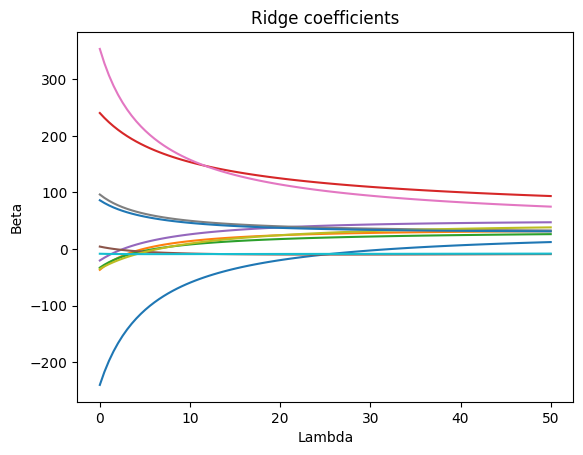

In [9]:
from sklearn.linear_model import Ridge
import numpy as np 

coefs = []
alphas = np.linspace(0.001, 50, 100)

for a in alphas:
  ridgereg = Ridge(alpha=a)
  ridgereg.fit(X_train_scaled,y_train)
  coefs.append(ridgereg.coef_)

# Plot
fig, ax = plt.subplots()
ax.plot(alphas, coefs)
ax.set(title="Ridge coefficients", xlabel="Lambda", ylabel="Beta");

## Lasso Regression

In contrast to ridge regression, lasso regression will not retain all predictors in the final model but force some of them to zero. The loss function for lasso is given as:

$$L(\boldsymbol\beta)=\sum_{i=1}^{n}\bigl(y_i - \mathbf X_i\,\boldsymbol\beta\bigr)^2\;+\;\lambda\sum_{j=1}^{p}\bigl\lvert \beta_j \bigr\rvert$$

Where:

- $L(\boldsymbol\beta)=\sum_{i=1}^{n}\bigl(y_i - \mathbf X_i\,\boldsymbol\beta\bigr)^2$ is the **residual sum of squares (RSS)**  
- $\lambda\sum_{j=1}^{p}\bigl\lvert \beta_j \bigr\rvert$ is the **L1 penalty** on the coefficients

You can see, that the concept is nearly identical, with the only difference being the form of the penalty term. Lasso uses the L1 norm ($\bigl\lvert \beta_j \bigr\rvert$) while Ridge uses the L2 norm ($\beta_j^2$).
Because of this geometric difference in the penalty, Lasso can produce sparse models by zeroing out irrelevant features, whereas Ridge keeps all predictors in the model but with smaller weights. 
Both balance the trade‐off between model fit (the RSS term) and complexity via the tuning parameter λ, typically chosen by cross‐validation.

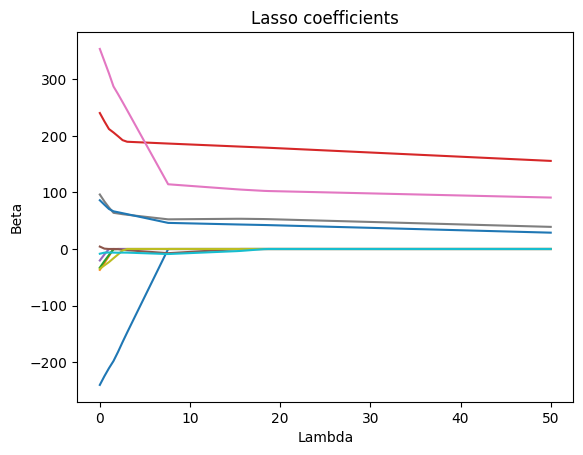

In [10]:
from sklearn.linear_model import Lasso
import numpy as np 

coefs = []
alphas = np.linspace(0.001, 50, 100)

for a in alphas:
  lassoreg = Lasso(alpha=a)
  lassoreg.fit(X_train_scaled,y_train)
  coefs.append(lassoreg.coef_)

# Plot
fig, ax = plt.subplots()
ax.plot(alphas, coefs)
ax.set(title="Lasso coefficients", xlabel="Lambda", ylabel="Beta");

## Why Ridge and Lasso Behave Differently: The Budget

When we use Ridge or Lasso regression, we are not just trying to fit the data perfectly — we are also trying to control how large the coefficients $\beta_j$ become. If we let them grow without any limits, the model could become too complex and overfit the data.

To prevent this, Ridge and Lasso add a kind of budget:
We are only allowed to spend a certain amount on the size of the coefficients. You can think of it like having a fixed amount of money that you have to divide up among all your coefficients.

This budget is enforced by a mathematical condition. For Lasso, the total absolute value of the coefficients must stay below a certain limit $t$:
    
  $$\sum_{j=1}^p \lvert \beta_j \rvert \;\le\; t$$

For Ridge, the total squared value of the coefficients must stay below this limit:
    
  $$\sum_{j=1}^p \beta_j^2 \;\le\; t$$

Even though both Ridge and Lasso limit the size of the coefficients, how they limit them is different — and this changes the behaviour of the models.

- In Lasso regression (left plot), the constraint $\sum |\beta_j| \le t$ forms a diamond shape (or a "pointy" version in higher dimensions). Because of these sharp corners, Lasso often drives some coefficients exactly to zero — which is why Lasso can create sparse models (feature selection).

- In Ridge regression (right plot), the constraint $\sum \beta_j^2 \le t$ forms a circular shape (or a sphere in higher dimensions). This means that Ridge tends to shrink coefficients smoothly but rarely sets them exactly to zero.


```{figure} figures/Budget_LassoRidge.png 
:name: Budget Lasso vs Ridge Regression
:alt: Budget
:align: center

The budget for Lasso and Ridge regression.
```


## Elastic Net Regression

Neither Ridge nor Lasso will universally be better than the other. The main difference between them is the coefficient selection:

- Lasso tends to shrink some coefficients all the way to zero, effectively performing feature selection by excluding less relevant variables.
- Ridge also shrinks coefficients toward zero, but does not eliminate any completely. Instead of selecting variables, it distributes the effect across all features.

Another point to note is their response to multicollinearity:

  - Ridge shares the weight among collinear features, keep them all (shrink but don’t zero)
  - Lasso chooses a subset (often just one) from each collinear group and zero out the rest

This is where elastic net regression comes into play. Elastic net is a combination of Ridge and Lasso:

$$
L(\boldsymbol\beta) \;=\;
\sum_{i=1}^{n}\bigl(y_i - \mathbf X_i\,\boldsymbol\beta\bigr)^2
\;+\;
\lambda
\Biggl[
\alpha \sum_{j=1}^{p}\bigl\lvert\beta_j\bigr\rvert
\;+\;
\frac{1 - \alpha}{2}\sum_{j=1}^{p}\beta_j^2
\Biggr]
$$

Here, the mixing parameter $\alpha\in[0,1]$ determines how much weight to give each penalty: when  $\alpha=1$ you recover pure Lasso (only an L1 penalty), and when  $\alpha=0$ you recover pure Ridge (only an L2 penalty); values in between blend the two. By combining these penalties, Elastic Net can both shrink coefficients (like Ridge) and select variables (like Lasso), while also tending to select or drop groups of correlated features together. In practice, you tune both λ (overall regularization strength) and $\alpha$ via cross-validation to find the best compromise between bias, variance, and sparsity for your particular dataset.

As a summary, we can look at coefficients estimated by all introduced methods:

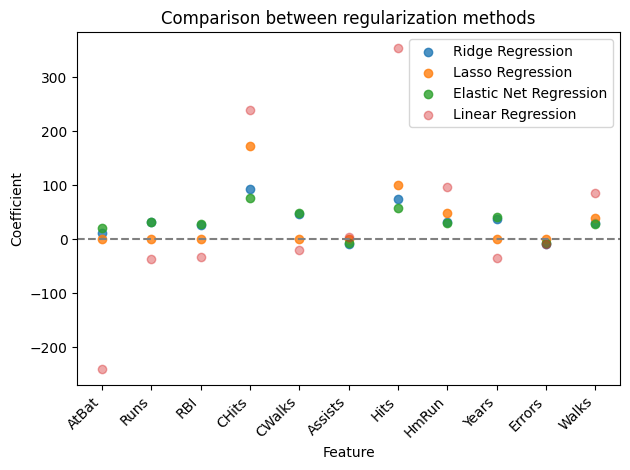

In [11]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Data related processing
hitters = sm.datasets.get_rdataset("Hitters", "ISLR").data
hitters_subset = hitters[[
    "Salary", "AtBat", "Runs", "RBI", "CHits", "CWalks",
    "Assists", "Hits", "HmRun", "Years", "Errors", "Walks"
]].copy()
hitters_subset.dropna(inplace=True)
y = hitters_subset["Salary"]
X = hitters_subset.drop(columns=["Salary"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Scale predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Regularization paths
lambda_range = np.linspace(0.001, 50, 100)

# Lasso CV
lasso_cv = LassoCV(alphas=lambda_range, cv=5).fit(X_train_scaled, y_train)

# Ridge CV
ridge_cv = RidgeCV(alphas=lambda_range, cv=5).fit(X_train_scaled, y_train)

# ElasticNet CV (blend of L1 & L2)
enet_cv = ElasticNetCV(
    alphas=lambda_range,
    l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],  # try a few mixing ratios
    cv=5
).fit(X_train_scaled, y_train)

# Ordinary Linear Regression
lr = LinearRegression().fit(X_train_scaled, y_train)

# Plotting coefficients
features = X.columns.tolist()
x_pos    = np.arange(len(features))

plt.scatter(x_pos, ridge_cv.coef_, alpha=0.8, label='Ridge Regression')
plt.scatter(x_pos, lasso_cv.coef_, alpha=0.8, label='Lasso Regression')
plt.scatter(x_pos, enet_cv.coef_,  alpha=0.8, label='Elastic Net Regression')
plt.scatter(x_pos, lr.coef_,       alpha=0.4, label='Linear Regression')

plt.axhline(0, color='gray', linestyle='--')
plt.xticks(x_pos, features, rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.title("Comparison between regularization methods")
plt.legend()
plt.tight_layout()
plt.show()

**Now it's your turn:** Head to the [exercise section](Exercises) for Exercise 2, in which you will implement a Lasso model.


## Principal Component Regression

TODO


## Partial Least Squares Regression

TODO